In [339]:
import pennylane as qml
from pennylane import qchem
import pennylane.numpy as pnp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from helper_functions import *

Exact ground state: -1.137284
Exact first excited state: -0.530775
Spectral gap: 0.606509
Optimizing with 3 variational parameters
Step = 0,  Energy = -1.11675923 Ha
Step = 1,  Energy = -1.11853182 Ha
Step = 2,  Energy = -1.12022310 Ha
Step = 3,  Energy = -1.12182997 Ha
Step = 4,  Energy = -1.12334708 Ha

Optimization complete


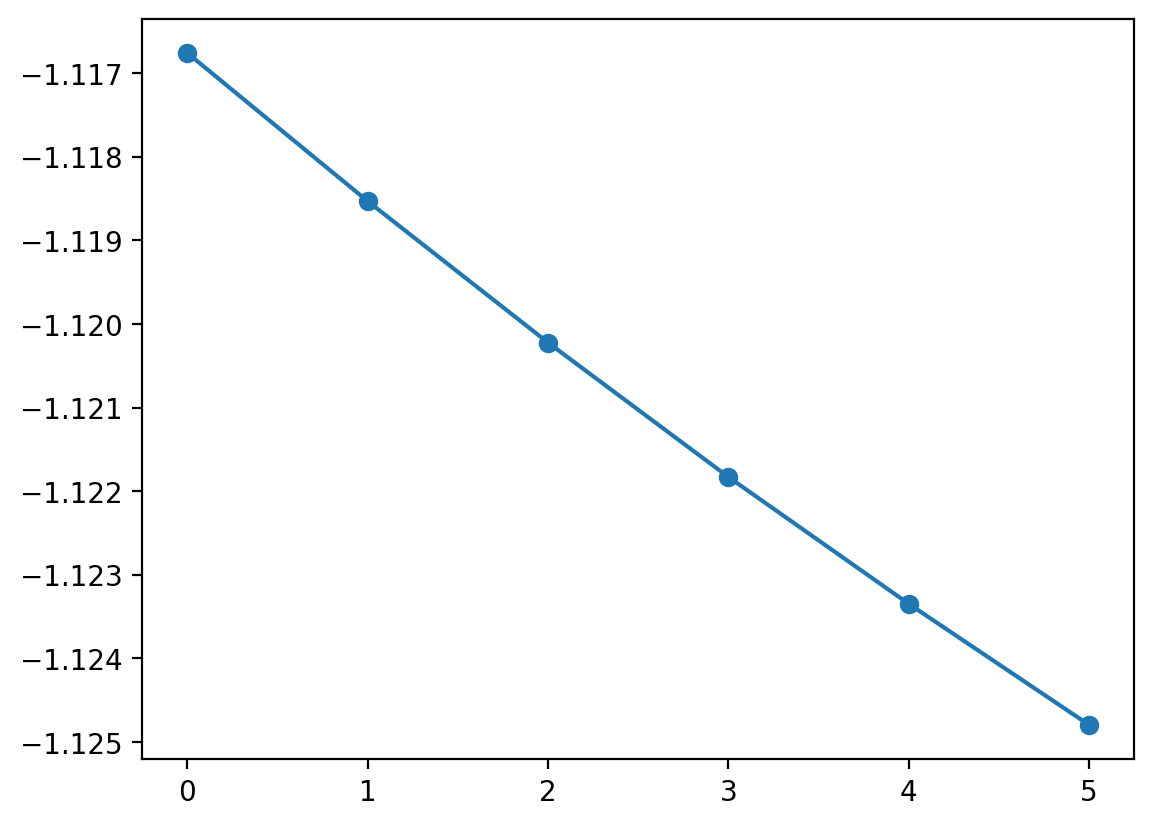


Final value of the ground-state energy = -1.12479576 Ha

Optimal value of the circuit parameter = [-0.00099626 -0.00096304  0.04976859]

Energy difference from exact = 0.01248806


In [340]:
mol = "H2"
H2_bl = np.array(['0.5', '0.54', '0.58', '0.62', '0.66', '0.7', '0.74', '0.742', '0.78', '0.82', '0.86', '0.9', '0.94', '0.98', '1.02', '1.06', '1.1', '1.14', '1.18', '1.22', '1.26', '1.3', '1.34', '1.38', '1.42', '1.46', '1.5', '1.54', '1.58', '1.62', '1.66', '1.7', '1.74', '1.78', '1.82', '1.86', '1.9', '1.94', '1.98', '2.02', '2.06', '2.1'])
bond_length =  H2_bl[[6]]
ex_ens = []
ex_sg = []
some_states = []
vqe_ens = []

for bl in bond_length:
    dataset = qml.data.load('qchem', molname=mol, basis="STO-3G", bondlength=bl)[0]
    molecule = dataset.molecule
    H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
    exact_energies = dataset.fci_spectrum
    print(f"Exact ground state: {exact_energies[0]:.6f}")
    print(f"Exact first excited state: {exact_energies[1]:.6f}")
    print(f"Spectral gap: {(exact_energies[1] - exact_energies[0]):.6f}")
    ex_ens.append(exact_energies[0])
    ex_sg.append(exact_energies[1] - exact_energies[0])

    dev = qml.device("default.qubit", wires=qubits, shots=None)

    # Define the Hartree-Fock state
    electrons = molecule.n_electrons
    hf = qml.qchem.hf_state(electrons, qubits)

    singles, doubles = qml.qchem.excitations(electrons, qubits)
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    wires = range(qubits)

    @qml.qnode(dev, interface="autograd")
    def cost_fn(params):
        # qml.BasisState(hf, wires=wires) #Occupies HF basis state
        # qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
        qml.UCCSD(params, wires, s_wires, d_wires, hf)
        return qml.expval(H)
        
    @qml.qnode(dev, interface="autograd")
    def circuit_state(params):
        qml.UCCSD(params, wires, s_wires, d_wires, hf)
        return qml.state()
    
    max_iterations = 5
    conv_tol = 1e-4

    # initialize optimizer
    opt = qml.AdamOptimizer(stepsize=1e-2)

    theta = pnp.zeros(len(singles) + len(doubles))
    print(f"Optimizing with {len(theta)} variational parameters")

    # store the values of the cost function
    energy = [cost_fn(theta)]

    # store the values of the circuit parameter
    angle = [theta]

    # opt_state = opt.init(theta)

    for n in range(max_iterations):
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

        # gradient = opt.step(cost_fn)(theta)
        # updates, opt_state = opt.update(gradient, opt_state)
        theta = opt.step(cost_fn, theta)

        angle.append(theta)
        energy.append(cost_fn(theta))

        conv = np.abs(energy[-1] - energy[-2])

        # if n % 5 == 0:
        some_states.append(circuit_state(theta))
        vqe_ens.append(energy[-1])

        if conv <= conv_tol:
            break

    print("\n" f"Optimization complete")
    plt.figure(dpi=200)
    plt.plot(energy, "o-")
    plt.show()

    print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
    print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
    print("\n" f"Energy difference from exact = {np.abs(energy[-1]-exact_energies[0]):.8f}")

    some_states.append(circuit_state(theta))
    vqe_ens.append(energy[-1])

In [341]:
some_states_array = np.array([np.asarray(some_states[i]) for i in range(len(some_states))])
# some_states_array = sp.sparse.lil_array(some_states_array)
some_states_array

array([[-1.96261557e-17+0.00000000e+00j,  0.00000000e+00+5.89805982e-17j,
         0.00000000e+00+0.00000000e+00j, -4.99997641e-03+0.00000000e+00j,
         0.00000000e+00-1.13281659e-28j,  1.96261557e-17+0.00000000e+00j,
        -5.08277688e-13+0.00000000e+00j,  0.00000000e+00-2.08527905e-17j,
         0.00000000e+00+2.01948392e-28j,  1.06717005e-12+0.00000000e+00j,
        -7.66646708e-20+0.00000000e+00j,  0.00000000e+00+1.49883572e-29j,
         9.99987500e-01+0.00000000e+00j,  0.00000000e+00-1.66533454e-16j,
         0.00000000e+00+0.00000000e+00j, -7.66646708e-20+0.00000000e+00j],
       [-7.85046229e-17+0.00000000e+00j,  0.00000000e+00-5.54667824e-32j,
         0.00000000e+00+5.72458747e-17j, -9.99327840e-03+0.00000000e+00j,
         0.00000000e+00+1.65436122e-24j,  1.23259519e-32+0.00000000e+00j,
         2.90763565e-08+0.00000000e+00j,  0.00000000e+00-4.04789469e-17j,
         0.00000000e+00+2.35513868e-16j, -3.75095990e-08+0.00000000e+00j,
         5.55052217e-17+0.00000000e+0

In [342]:
S = get_overlap_matrix(some_states_array)
print(np.linalg.cond(S))

inf


In [343]:
dataset = qml.data.load('qchem', molname=mol, basis="STO-3G", bondlength=1.1)[0]
molecule = dataset.molecule
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
exact_energies = dataset.fci_spectrum
print(exact_energies[0])

mat = H.matrix()
evals, evecs = np.linalg.eigh(mat)
evecs[:,0]

-1.0791924385860894


array([ 0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        2.05413724e-001+0.j,  2.22044605e-016+0.j, -7.39557099e-032+0.j,
        2.18952885e-047+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        9.65227537e-048+0.j, -1.49813643e-095+0.j, -1.33061245e-110+0.j,
       -9.78675228e-001+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j])

In [344]:
exact_per_bl = []
ec_per_bl = []
exact_sg_per_bl = []
ec_sg_per_bl = []
exact_excited = []
ec_excited = []
exact_sg_2 = []
ec_sg_2 = []

for bl in H2_bl:
    dataset = qml.data.load('qchem', molname=mol, basis="STO-3G", bondlength=bl)[0]
    molecule = dataset.molecule
    H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
    exact_energies = dataset.fci_spectrum
    print(exact_energies)
    # print(exact_energies[1], "dataset")
    H_mat = H.sparse_matrix()
    # exact_energies = np.linalg.eigvalsh(H_mat.todense())
    # print(exact_energies[1], "diag")
    red_H = get_reduced_hamiltonian(H_mat, some_states_array)
    S = get_overlap_matrix(some_states_array)
    ec_en, ec_vec, _, chosen = optimize_subspace(some_states_array, red_H, S, H_mat, exact_energies[0], np.zeros(len(some_states_array[0])), verbose=True)
    chosen_states = np.array([some_states_array[i] for i in chosen])

    S = get_overlap_matrix(chosen_states)
    H_ij = get_reduced_hamiltonian(H_mat, chosen_states)

    evals, evecs = sp.linalg.eigh(H_ij,S)

    # first_ex_evecs = evecs[:,1]
    # first_ex_full_vec = np.zeros(len(some_states_array[0]), dtype=complex)

    # for i in range(len(chosen)):
    #     first_ex_full_vec += first_ex_evecs[i]*chosen_states[i]

    # pretty_print(first_ex_full_vec)

    ec_sg_per_bl.append(evals[1]-evals[0])
    exact_sg_per_bl.append(exact_energies[1]-exact_energies[0])
    ec_sg_2.append(evals[2]-evals[0])
    exact_sg_2.append(exact_energies[3]-exact_energies[0])
    exact_per_bl.append(exact_energies[0])
    ec_per_bl.append(evals[0])

    exact_excited.append(exact_energies[1])
    ec_excited.append(evals[1])



[-1.05516074 -0.3521754  -0.3521754  -0.05432522 -0.07074308 -0.07074308
 -0.07074308]

Gaussian state 4 has min energy -1.0499535036068497 (exact is -1.0551607375072107)
Fidelity: 0.0

### 2 states ###
Adding gaussian state 0 gives energy -1.0551532114437756 (exact is -1.0551607375072107)
Relative energy difference: 7.132622706286521e-06
Fidelity: 0.0
Choices left: 3
Ill-conditioned choices: 1
Chosen: [np.int64(4), np.int64(0)]
Num iterations left: 4

### 3 states ###
Adding gaussian state 1 gives energy -1.0551607375072023 (exact is -1.0551607375072107)
Relative energy difference: 7.996596809586586e-15
Fidelity: 0.0
Choices left: 2
Ill-conditioned choices: 1
Chosen: [np.int64(4), np.int64(0), np.int64(1)]
Num iterations left: 3

### 4 states ###
Adding gaussian state 3 gives energy -1.0551607375072103 (exact is -1.0551607375072107)
Relative energy difference: 4.208735162940308e-16
Fidelity: 0.0
Choices left: 1
Ill-conditioned choices: 1
Chosen: [np.int64(4), np.int64(0), np.int64(1),

Text(0.5, 1.0, 'H2 Spectral Gap')

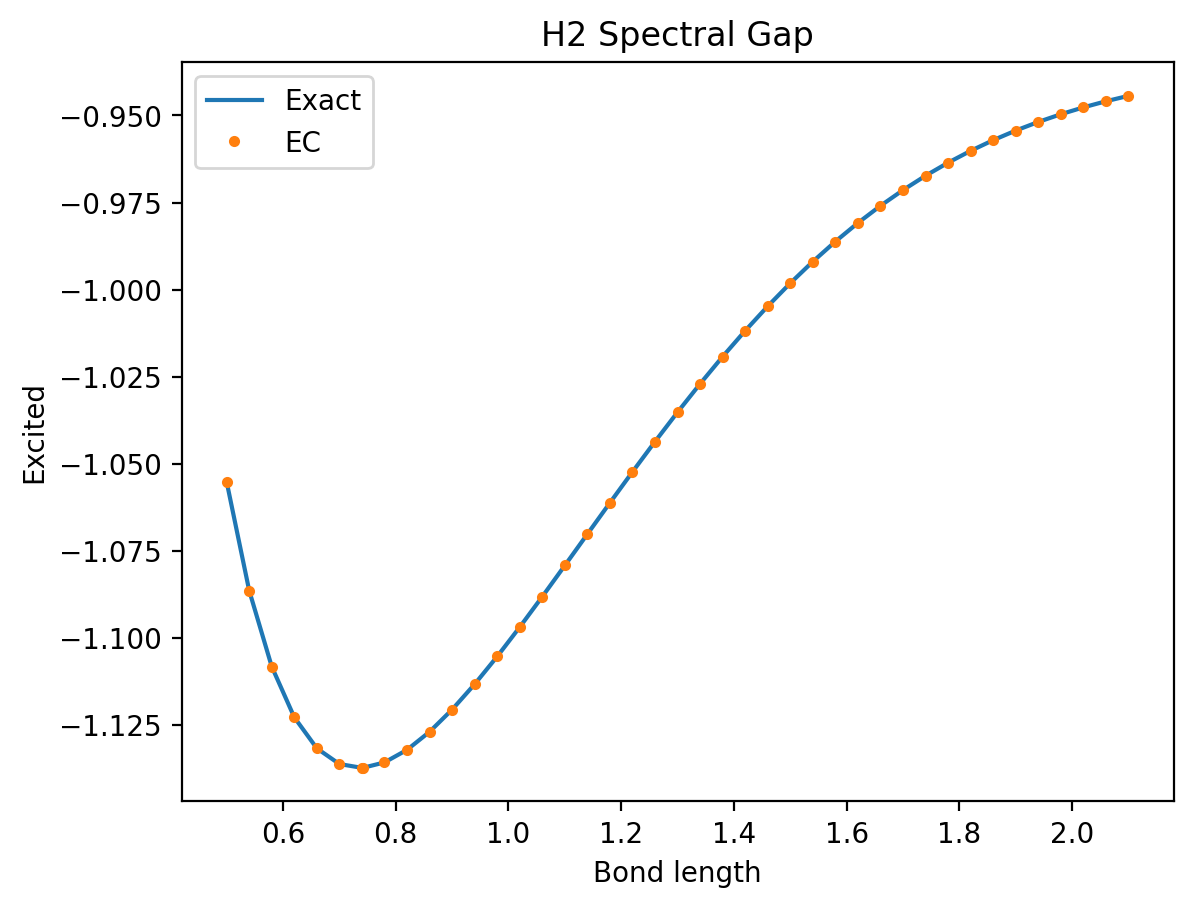

In [345]:
from matplotlib import pyplot as plt
plt.figure(dpi=200)
# plt.plot(np.array(H2_bl, dtype=float), exact_excited, label="Exact ex")
# plt.plot(np.array(H2_bl,dtype=float), ec_excited, label="EC ex")
plt.plot(np.array(H2_bl,dtype=float), exact_per_bl, label="Exact")
plt.plot(np.array(H2_bl,dtype=float), ec_per_bl, ".", label="EC")
# plt.plot(np.array(H2_bl,dtype=float), exact_sg_per_bl, label="Exact")
# plt.plot(np.array(H2_bl,dtype=float), ec_sg_per_bl, label="EC")
# plt.plot(np.array(H2_bl,dtype=float), exact_sg_2, label="Exact")
# plt.plot(np.array(H2_bl,dtype=float), ec_sg_2, label="EC")
plt.xlabel("Bond length")
plt.ylabel("Excited")
plt.legend()
plt.title("H2 Spectral Gap")

In [304]:
exact_sg_2

[np.float64(1.0008355158567968),
 np.float64(0.9087756085981499),
 np.float64(0.8385016442517506),
 np.float64(0.7734137470805655),
 np.float64(0.7780515659832195),
 np.float64(0.657734476703843),
 np.float64(0.6065086039622604),
 np.float64(0.6040539274519515),
 np.float64(0.5592333104048087),
 np.float64(0.5711044523494835),
 np.float64(0.5583230920063795),
 np.float64(0.546313735390498),
 np.float64(0.5297712408481448),
 np.float64(0.5044747869023876),
 np.float64(0.48106207186113914),
 np.float64(0.459392133572071),
 np.float64(0.49687229849456516),
 np.float64(0.48892870759238105),
 np.float64(0.4037715257780571),
 np.float64(0.38808439877875345),
 np.float64(0.37371016813308955),
 np.float64(0.46302181154990296),
 np.float64(0.3486622104950957),
 np.float64(0.4533913405589306),
 np.float64(0.4493553301153127),
 np.float64(0.4458157697145153),
 np.float64(0.31177067945266057),
 np.float64(0.4401456819476278),
 np.float64(0.43797013754218994),
 np.float64(0.4362012110074026),
 np.f

In [287]:
ec_sg_per_bl

[np.float64(1.3221228420501117),
 np.float64(0.9087755788565953),
 np.float64(1.1835999170673326),
 np.float64(1.1228853550859723),
 np.float64(0.7212388547888199),
 np.float64(0.8036044218916853),
 np.float64(0.6402064652922613),
 np.float64(0.6377726202999128),
 np.float64(0.8525505283172724),
 np.float64(0.8278771122429142),
 np.float64(0.6971482631691711),
 np.float64(0.6625486874477764),
 np.float64(0.7391846815261316),
 np.float64(0.7111982319098483),
 np.float64(0.6854964498362665),
 np.float64(0.6911151809008165),
 np.float64(0.6698316814054546),
 np.float64(0.6562224665179525),
 np.float64(0.6385197887188938),
 np.float64(0.6224110976323759),
 np.float64(0.618630683769501),
 np.float64(0.17995009740853274),
 np.float64(0.16303432565384324),
 np.float64(0.14739502716189423),
 np.float64(0.1329785895628579),
 np.float64(0.1197239261325792),
 np.float64(0.10756368079353196),
 np.float64(0.09643876773660687),
 np.float64(0.08628844198144303),
 np.float64(0.07705294496013493),
 np.

In [259]:
H2_bl, exact_sg_per_bl

(array(['0.5', '0.54', '0.58', '0.62', '0.66', '0.7', '0.74', '0.742',
        '0.78', '0.82', '0.86', '0.9', '0.94', '0.98', '1.02', '1.06',
        '1.1', '1.14', '1.18', '1.22', '1.26', '1.3', '1.34', '1.38',
        '1.42', '1.46', '1.5', '1.54', '1.58', '1.62', '1.66', '1.7',
        '1.74', '1.78', '1.82', '1.86', '1.9', '1.94', '1.98', '2.02',
        '2.06', '2.1'], dtype='<U5'),
 [np.float64(0.7029853397618697),
  np.float64(0.6835815248477475),
  np.float64(0.6650076909341819),
  np.float64(0.647268286537332),
  np.float64(0.6303662773101366),
  np.float64(0.6143033300149906),
  np.float64(0.6065086039622618),
  np.float64(0.6896912619796669),
  np.float64(0.6537175292213245),
  np.float64(0.5711044523494837),
  np.float64(0.5867317982968879),
  np.float64(0.5571221691642051),
  np.float64(0.5297712408481446),
  np.float64(0.5244984435242513),
  np.float64(0.5146357595251151),
  np.float64(0.45939213357207176),
  np.float64(0.43934889167211255),
  np.float64(0.420835924975398